In [108]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras.optimizers import SGD
import numpy as np
from PIL import Image
import sqlite3
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os

In [109]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import Scatter
%matplotlib inline
init_notebook_mode(connected=True)
print("plotly version:", __version__)

plotly version: 4.5.2


In [110]:
# load major features and clinical factors
data_path = "./Data/"
output_path = "./Results/"
features = pd.read_excel(data_path + "all_major_block_features.xlsx", index_col=0)
fp = [ 'GLSZM_GrayLevelVariance', 'WAVELET_LLH_glcm_Idm',
       'WAVELET_LLH_glcm_Id', 'WAVELET_HHH_glrlm_RunEntropy', 'VFat', 'SFat', 'Age', 'Gender', 'IsMS',
       'IsCO', 'IsVO', 'IsIR', 'IsCTVO']

features = features[fp]

In [ ]:
#start build sankey diagram

In [ ]:
# build left panel
ffeatures = features.copy()
for col in features.columns[:6]:
    mn = np.mean(features.ix[:,col]) 
    ffeatures.ix[features.ix[:,col] > mn,col] = 1
    ffeatures.ix[features.ix[:,col] <=mn,col] = 0
ffeatures.ix[features.Age > 4,'Age'] = 1
ffeatures.ix[features.Age <= 4,'Age'] = 0
lfeatures = ffeatures.copy()
lfeatures.loc[:,"A"] = "M"
lfeatures.loc[ffeatures.Gender>0,"A"] = "F"

lfeatures.loc[:,"B"] = "L"
lfeatures.loc[ffeatures.Age>0,"B"] = "H"

lfeatures.loc[:,"C"] = "L"
lfeatures.loc[ffeatures.SFat>0,"C"] = "H"

lfeatures.loc[:,"D"] = "L"
lfeatures.loc[ffeatures.VFat>0,"D"] = "H"

combination = list(lfeatures.A + lfeatures.B + lfeatures.C + lfeatures.D)
lfeatures.loc[:,"Combo1"] = combination
uniqCom = set(combination)
print(uniqCom)

In [116]:
# build middle panel
lfeatures.loc[:,"E"] = "L"
lfeatures.loc[ffeatures['WAVELET_HHH_glrlm_RunEntropy']>0,"E"] = "H"

lfeatures.loc[:,"F"] = "L"
lfeatures.loc[ffeatures['GLSZM_GrayLevelVariance']>0,"F"] = "H"

lfeatures.loc[:,"G"] = "L"
lfeatures.loc[ffeatures['WAVELET_LLH_glcm_Id']>0,"G"] = "H"

lfeatures.loc[:,"H"] = "L"
lfeatures.loc[ffeatures["WAVELET_LLH_glcm_Idm"]>0,"H"] = "H"

combination = list(lfeatures.E + lfeatures.F + lfeatures.G+ lfeatures.H)
lfeatures.loc[:,"Combo2"] = combination
uniqCom1 = set(combination)
print(uniqCom1)

In [118]:
# build right panel (metabolic outcomes)
lfeatures.loc[:,"I"] = "N"
lfeatures.loc[ffeatures.IsIR>0,"I"] = "Y"

lfeatures.loc[:,"J"] = "N"
lfeatures.loc[ffeatures.IsMS>0,"J"] = "Y"
combination = list(lfeatures.I + lfeatures.J )
lfeatures.loc[:,"Combo3"] = combination
uniqCom2 = set(combination)
print(uniqCom2)

In [121]:
labels = []
labels.extend(list(uniqCom))
labels.extend(list(uniqCom1))
labels.extend(list(uniqCom2))

In [122]:
labels

['FLHH',
 'MHHH',
 'FLHL',
 'MLHL',
 'FHHL',
 'FHLL',
 'FLLL',
 'MLHH',
 'FHLH',
 'FHHH',
 'MHLL',
 'MLLH',
 'MLLL',
 'MHLH',
 'LLHH',
 'HHLL',
 'HHHH',
 'HLLL',
 'HLLH',
 'LHHH',
 'HLHH',
 'LLLL',
 'LHLL',
 'NY',
 'YY',
 'YN',
 'NN']

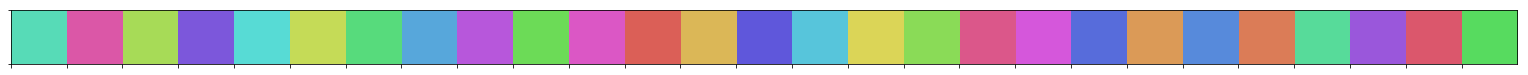

In [124]:
# color for each item
import seaborn as sns
colors = sns.color_palette('hls', len(labels)).as_hex()
from random import shuffle
shuffle(colors)
sns.palplot(colors)
labelFrame = pd.DataFrame(np.array(colors), index=labels, columns=['cl'])

In [126]:
labelFrame

,cl
FLHH,#57dbb7
MHHH,#db57a7
FLHL,#a7db57
MLHL,#7c57db
FHHL,#57dbd5
FHLL,#c5db57
FLLL,#57db7c
MLHH,#57a7db
FHLH,#b757db
FHHH,#6cdb57


In [ ]:
# connect edges between left and middle panels
from collections import defaultdict
index = 0
indexList = []
for item in labelFrame.iterrows():
    sub = lfeatures[lfeatures.Combo1 == item[0]]
    
    targets = defaultdict(int)

    for row in sub.iterrows():
        pos = np.where(np.array(labels)==row[1]['Combo2'])[0][0]
        targets[pos] = targets[pos] + 1
    for (key, value) in targets.items():   
        indexList.append([index, key , value, labelFrame.ix[index,"cl"]])
    index = index + 1
    if index >= len(uniqCom):
        break

In [ ]:
# connect edges between middle and right panels

for item in labelFrame.ix[index:,:].iterrows():
    sub = lfeatures[lfeatures.Combo2 == item[0]]
    
    targets = defaultdict(int)

    for row in sub.iterrows():
        pos = np.where(np.array(labels)==row[1]['Combo3'])[0][0]
        targets[pos] = targets[pos] + 1
    for (key, value) in targets.items():   
        indexList.append([index, key , value, labelFrame.ix[key,"cl"]])
    index = index + 1
    if index >= len(uniqCom) + len(uniqCom1):
        break

In [132]:
print(indexList)

[[0, 22, 1, '#57dbb7'],
 [0, 20, 2, '#57dbb7'],
 [0, 15, 1, '#57dbb7'],
 [1, 20, 2, '#db57a7'],
 [1, 15, 32, '#db57a7'],
 [1, 14, 1, '#db57a7'],
 [1, 17, 3, '#db57a7'],
 [2, 14, 18, '#a7db57'],
 [2, 17, 1, '#a7db57'],
 [2, 20, 4, '#a7db57'],
 [2, 15, 1, '#a7db57'],
 [3, 14, 1, '#7c57db'],
 [3, 15, 14, '#7c57db'],
 [3, 21, 1, '#7c57db'],
 [3, 22, 4, '#7c57db'],
 [3, 16, 1, '#7c57db'],
 [3, 17, 1, '#7c57db'],
 [4, 14, 7, '#57dbd5'],
 [4, 21, 1, '#57dbd5'],
 [4, 19, 1, '#57dbd5'],
 [5, 14, 31, '#c5db57'],
 [6, 14, 65, '#57db7c'],
 [7, 15, 162, '#57a7db'],
 [7, 20, 1, '#57a7db'],
 [7, 14, 1, '#57a7db'],
 [7, 17, 6, '#57a7db'],
 [7, 22, 10, '#57a7db'],
 [7, 19, 1, '#57a7db'],
 [7, 21, 1, '#57a7db'],
 [7, 18, 1, '#57a7db'],
 [8, 20, 1, '#b757db'],
 [9, 20, 5, '#6cdb57'],
 [9, 14, 2, '#6cdb57'],
 [9, 16, 2, '#6cdb57'],
 [9, 15, 1, '#6cdb57'],
 [10, 14, 35, '#db57c5'],
 [10, 21, 5, '#db57c5'],
 [10, 19, 1, '#db57c5'],
 [10, 22, 1, '#db57c5'],
 [10, 15, 1, '#db57c5'],
 [10, 20, 1, '#db57c5'],
 

In [135]:
# indexList
def hextorgba(hex):
    if hex.find("rgba")!=-1:
        return hex.replace("1.0)", "0.6)")
    h = hex.lstrip('#')
    tp = tuple(int(h[i:i+2], 16) for i in (0, 2 ,4))
#     print(tp[0]

    s = 'rgba({},{},{},{})'.format(tp[0] ,tp[1],tp[2],0.7)
    return s

In [138]:
# build sandkey diagram
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 8,
      thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  labelFrame.index,
      color = labelFrame['cl']
        
    ),
    link = dict(
      source = np.array(indexList)[:, 0],
      target = np.array(indexList)[:, 1],
      value = np.array(indexList)[:, 2],
      color = [hextorgba(item) for item in np.array(indexList)[:, 3]],
  )
)

layout =  dict(

    height = 720,
    font = dict(
      size = 11,
      family = "Times New Roman",
    ),    

)


In [139]:
#plot sankey diagram in plotly
# fig = dict(data=[data_trace], layout=layout)
# iplot(fig, validate=False)


In [140]:
# save sankey diagram to files
import plotly
import plotly.io as pio
plotly.io.orca.config.executable = '/anaconda3/orca.sh' #make sure orca was installed
plotly.io.orca.config.save() 
pio.write_image(fig, output_path + 'adipose_sankey_diagram.svg', width=800, height=550)
pio.write_image(fig, output_path + 'adipose_sankey_diagram.pdf', width=800, height=550)


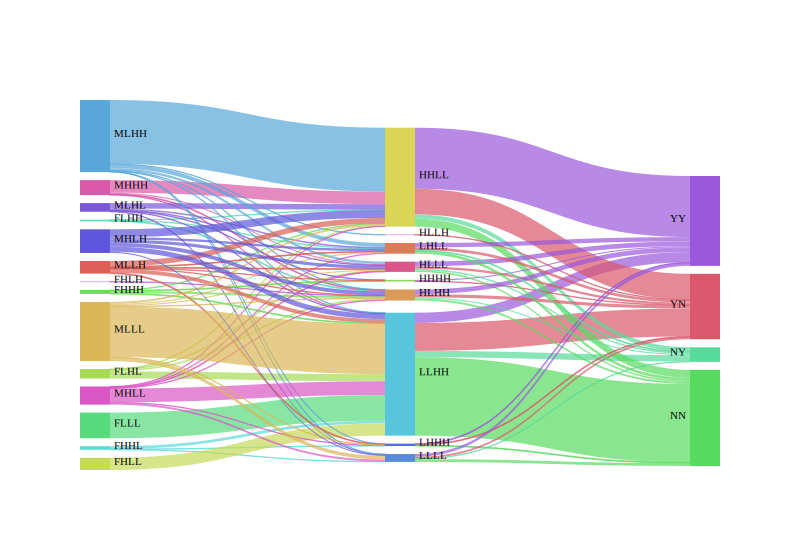

CPU times: user 166 ms, sys: 3.49 ms, total: 169 ms
Wall time: 205 ms


In [142]:
# plot sankey diagram as picture
%%time
img_bytes = pio.to_image(fig, format='svg', width=800, height=550)
from IPython.display import SVG, display
display(SVG(img_bytes))